In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def RMSLE(actual, predicted):

    predicted = np.array([np.log(np.abs(x+1.0)) for x in predicted])  # doing np.abs for handling neg values  
    actual = np.array([np.log(np.abs(x+1.0)) for x in actual])
    log_err = actual-predicted
    
    return 1000*np.sqrt(np.mean(log_err**2))


In [3]:
train=pd.read_csv('train_demand.csv')
test=pd.read_csv('test_demand.csv')
submit=pd.read_csv('sample_demand.csv')

In [4]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [5]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0


In [6]:
train.shape,test.shape

((150150, 9), (13860, 8))

Since, the data is on (store X sku) level, let's make a separate identifier to pick it later. Below, I have concatenated the store and sku id by making new column store_sku.
I have also checked if the number of such combinations is same across the train and test set. By making sure it is 0, we can rest assured that no cold-start needs to be done.



In [7]:
train['store_sku']=(train['store_id'].astype('str')+'-'+train['sku_id'].astype('str'))
test['store_sku']=(test['store_id'].astype('str')+'-'+test['sku_id'].astype('str'))

In [8]:
len(train['store_sku'].unique())-len(test['store_sku'].unique())

0

In [9]:
train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
store_sku          0
dtype: int64

Notice that one entry for total_price is null in the train set. Lets replace it with the base_price for now.

In [10]:
temp=train[train['total_price'].isnull()]['base_price']

In [11]:
train['total_price']=train['total_price'].fillna(temp)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150150 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
 9   store_sku        150150 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 11.5+ MB


In [13]:
colu=['record_ID',
 'week',
 'store_id',
 'sku_id',
 'total_price',
 'base_price',
 'is_featured_sku',
 'is_display_sku',
 'store_sku',
]

In [14]:
print('Checking Data distribution for Train! \n')
for col in colu:
    print(f'Distinct entries in {col}:{train[col].nunique()}')
    print(f'common number of {col} entries in test and train:{len(np.intersect1d(train[col].unique(),test[col].unique()))}')

Checking Data distribution for Train! 

Distinct entries in record_ID:150150
common number of record_ID entries in test and train:0
Distinct entries in week:130
common number of week entries in test and train:0
Distinct entries in store_id:76
common number of store_id entries in test and train:76
Distinct entries in sku_id:28
common number of sku_id entries in test and train:28
Distinct entries in total_price:646
common number of total_price entries in test and train:440
Distinct entries in base_price:572
common number of base_price entries in test and train:364
Distinct entries in is_featured_sku:2
common number of is_featured_sku entries in test and train:2
Distinct entries in is_display_sku:2
common number of is_display_sku entries in test and train:2
Distinct entries in store_sku:1155
common number of store_sku entries in test and train:1155


In [15]:
train.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.628502,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.310400,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [16]:
pd.DataFrame(train['units_sold'].describe(percentiles=(1,0.99,0.9,0.75,0.5,0.3,0.1,0.01)))

,units_sold
count,150150.000000
mean,51.674206
std,60.207904
min,1.000000
1%,4.000000
10%,11.000000
30%,22.000000
50%,35.000000
75%,62.000000
90%,106.000000


WE could see that there is one extreme outlier which is making our data heavily right skewed. Even the 99% of units_sold is 283 only

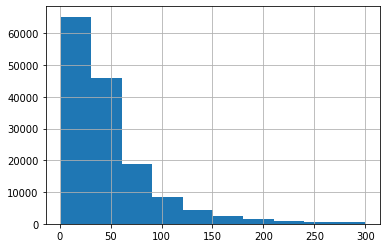

In [17]:
(train[train['units_sold']<=300].units_sold).hist()

Just by removing that outlier we won't get normal distribution. Even then we are having right skewed data. So we have opt for some normalization technique

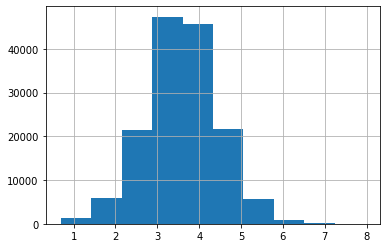

In [18]:
np.log1p(train['units_sold']).hist()

In [19]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [20]:
le.fit(train['store_sku'])

LabelEncoder()

In [21]:
train['store_sku']=le.transform(train['store_sku'])

In [22]:
test['store_sku']=le.transform(test['store_sku'])

In [23]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_sku
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20,56
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28,57
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19,58
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44,55
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52,59


In [24]:
#Making price based new features
train['price_diff']=train['base_price']-train['total_price']
train['relative_diff_base']=train['price_diff']/train['base_price']
train['relative_diff_total']=train['price_diff']/train['total_price']

In [25]:
test['price_diff']=test['base_price']-test['total_price']
test['relative_diff_base']=test['price_diff']/test['base_price']
test['relative_diff_total']=test['price_diff']/test['total_price']

In [26]:
# Studying correlation between features and the target. This will help us in regression later.
cols = ['base_price', 'total_price', 'price_diff', 'relative_diff_base', 'relative_diff_total'
        , 'is_featured_sku', 'is_display_sku', 'units_sold','store_sku']
train[cols].corr().loc['units_sold']


base_price            -0.140032
total_price           -0.235634
price_diff             0.278283
relative_diff_base     0.364841
relative_diff_total    0.365690
is_featured_sku        0.337751
is_display_sku         0.362662
units_sold             1.000000
store_sku              0.005503
Name: units_sold, dtype: float64

Lets do a baseline regression with htese features

In [27]:
cols.remove('units_sold')


In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X=train[cols]
y=np.log1p(train['units_sold'])   # Transforming target into normal via log

In [30]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=1)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(120120, 8) (30030, 8) (120120,) (30030,)


In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
reg=RandomForestRegressor()

In [33]:
reg.fit(X_train,y_train)

RandomForestRegressor()

In [34]:
rf_preds=reg.predict(X_val)

In [35]:
from sklearn.metrics import mean_squared_log_error

In [36]:
RMSLE(np.exp(y_val),np.exp(rf_preds))

413.8010132416207

SKU level base model fitting:

    Since the features store and sku id have high cardinality. we shall encode it using MEstimate encoder

In [37]:
from category_encoders import TargetEncoder,MEstimateEncoder

In [38]:
encoder=MEstimateEncoder()

In [39]:
encoder.fit(train['store_id'],train['units_sold'])

MEstimateEncoder(cols=[])

In [40]:
train['store_encoded'] = encoder.transform(train['store_id'], train['units_sold'])
test['store_encoded'] = encoder.transform(test['store_id'])

In [41]:
encoder.fit(train['sku_id'], train['units_sold'])
train['sku_encoded'] = encoder.transform(train['sku_id'], train['units_sold'])
test['sku_encoded'] = encoder.transform(test['sku_id'])


In [42]:
train.tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_sku,price_diff,relative_diff_base,relative_diff_total,store_encoded,sku_encoded
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38,1148,0.0000,0.000000,0.000000,9984,223245
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30,1147,0.0000,0.000000,0.000000,9984,223153
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31,1149,126.1125,0.260677,0.352590,9984,245338
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12,1153,49.8750,0.260223,0.351759,9984,547934
150149,212644,09/07/13,9984,679023,234.4125,234.4125,0,0,15,1154,0.0000,0.000000,0.000000,9984,679023


In [43]:
skus = train.sku_id.unique()

In [44]:
cols_to_use = cols + ['store_encoded', 'sku_encoded']


Now, we would also like to incorporate the store_id as one of the defining features of the multiple models that we are building. But as the problem statement defines, there are 76 different models for each one of them across each sku will be tough
We will be using LightGBM's categorical features' input to our rescue. 

LightGBM regressor

In [45]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold


In [46]:
cols_to_use

['base_price',
 'total_price',
 'price_diff',
 'relative_diff_base',
 'relative_diff_total',
 'is_featured_sku',
 'is_display_sku',
 'store_sku',
 'store_encoded',
 'sku_encoded']

In [47]:
cols_to_use += ['store_id', 'sku_id']
# For defining categorical features to the model, we will build `cat_cols`
cat_cols = ['is_featured_sku', 'is_display_sku', 'store_id', 'sku_id']

In [75]:
cols1=['base_price',
 'total_price',
 'price_diff',
 'relative_diff_base',
 'relative_diff_total',
 'is_featured_sku',
 'is_display_sku',
 'store_sku',
 'store_encoded',
 'sku_encoded']


In [76]:
cols1 += ['store_id', 'sku_id']

In [84]:
Xtest1=test[cols1]

In [85]:
finpred=m.predict(Xtest1)

In [86]:
finpred

array([3.11638859, 2.97830416, 3.09594904, ..., 3.07897424, 2.38017725,
       2.34630799])

In [89]:
finpred1=np.expm1(finpred)

In [90]:
finpred1

array([21.56474178, 18.65445755, 21.10821019, ..., 20.73609491,
        9.80681818,  9.4469283 ])

In [92]:
submit.head()

,record_ID,units_sold
0,212645,0
1,212646,0
2,212647,0
3,212648,0
4,212649,0


In [93]:
submit['units_sold'] = finpred1
submit.to_csv('lgb_demand_sku.csv', index = False)


In [79]:
X=train[cols1]
y=np.log1p(train['units_sold']) #Transforming target into normal via log

In [80]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape)


(120120, 12) (120120,) (30030, 12) (30030,)


In [50]:
Xtest=test[cols_to_use]

In [81]:
m = LGBMRegressor(n_estimators=3500, 
                  num_leaves=127, 
                  max_depth=8,
                  min_child_samples=4,
                  learning_rate=0.02,
                  colsample_bytree=0.4,
                  reg_alpha=0.5,
                  reg_lambda=2)
m.fit(Xtrain,ytrain,eval_set=[(Xval, yval)],early_stopping_rounds=100, verbose=100,eval_metric='rmse')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.55931	valid_0's l2: 0.312828
[200]	valid_0's rmse: 0.49014	valid_0's l2: 0.240238
[300]	valid_0's rmse: 0.456078	valid_0's l2: 0.208007
[400]	valid_0's rmse: 0.437146	valid_0's l2: 0.191096
[500]	valid_0's rmse: 0.425245	valid_0's l2: 0.180833
[600]	valid_0's rmse: 0.417304	valid_0's l2: 0.174142
[700]	valid_0's rmse: 0.411496	valid_0's l2: 0.169329
[800]	valid_0's rmse: 0.407449	valid_0's l2: 0.166015
[900]	valid_0's rmse: 0.40439	valid_0's l2: 0.163531
[1000]	valid_0's rmse: 0.402008	valid_0's l2: 0.16161
[1100]	valid_0's rmse: 0.399942	valid_0's l2: 0.159953
[1200]	valid_0's rmse: 0.39812	valid_0's l2: 0.1585
[1300]	valid_0's rmse: 0.396621	valid_0's l2: 0.157308
[1400]	valid_0's rmse: 0.395357	valid_0's l2: 0.156307
[1500]	valid_0's rmse: 0.394237	valid_0's l2: 0.155423
[1600]	valid_0's rmse: 0.393213	valid_0's l2: 0.154617
[1700]	valid_0's rmse: 0.392264	valid_0's l2: 0.153871
[1800]	valid_0's rm

LGBMRegressor(colsample_bytree=0.4, learning_rate=0.02, max_depth=8,
              min_child_samples=4, n_estimators=3500, num_leaves=127,
              reg_alpha=0.5, reg_lambda=2)

In [82]:
lgpred=m.predict(Xval)

In [83]:
RMSLE(np.exp(yval),np.exp(lgpred))

366.9707174199718

In [84]:
Xtest1=test[cols1]

In [85]:
finpred=m.predict(Xtest1)

In [86]:
finpred

array([3.11638859, 2.97830416, 3.09594904, ..., 3.07897424, 2.38017725,
       2.34630799])

In [89]:
finpred1=np.expm1(finpred)

In [90]:
finpred1

array([21.56474178, 18.65445755, 21.10821019, ..., 20.73609491,
        9.80681818,  9.4469283 ])

In [92]:
submit.head()

,record_ID,units_sold
0,212645,0
1,212646,0
2,212647,0
3,212648,0
4,212649,0


In [93]:
submit['units_sold'] = finpred1
submit.to_csv('lgb_demand_sku.csv', index = False)


### Extracting Date time features

In [54]:
from datetime import datetime

In [55]:
train['week'] = train['week'].astype('str')
train['week'] = [datetime.strptime(x, '%d/%m/%y') for x in train['week']]


In [56]:
test['week']=test['week'].astype('str')
test['week']=[datetime.strptime(x,'%d/%m/%y') for x in test['week']]

In [57]:
train['year'] = train['week'].dt.year
train['date'] = [x.day for x in train['week']]
train['month'] = train['week'].dt.month
train['weekday'] = train['week'].dt.dayofweek
train['weeknum'] = train['week'].dt.weekofyear
train['wom']=train['week'].apply(lambda d:(d.day-1)//7+1)

C:\Users\91999\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [58]:
test['year'] = test['week'].dt.year
test['date'] = [x.day for x in test['week']]
test['month'] = test['week'].dt.month
test['weekday'] = test['week'].dt.dayofweek
test['weeknum'] = test['week'].dt.weekofyear
test['wom']=test['week'].apply(lambda d:(d.day-1)//7+1)

C:\Users\91999\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [94]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_sku,...,relative_diff_base,relative_diff_total,store_encoded,sku_encoded,year,date,month,weekday,weeknum,wom
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,56,...,0.11465,0.129496,8091,216418,2011,17,1,0,3,3
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,57,...,0.00000,0.000000,8091,216419,2011,17,1,0,3,3
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,58,...,0.00000,0.000000,8091,216425,2011,17,1,0,3,3
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,55,...,0.00000,0.000000,8091,216233,2011,17,1,0,3,3
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,59,...,0.00000,0.000000,8091,217390,2011,17,1,0,3,3


In [95]:
cols_to_use=[c for c in test.columns]

In [96]:
cols_to_use

['record_ID',
 'week',
 'store_id',
 'sku_id',
 'total_price',
 'base_price',
 'is_featured_sku',
 'is_display_sku',
 'store_sku',
 'price_diff',
 'relative_diff_base',
 'relative_diff_total',
 'store_encoded',
 'sku_encoded',
 'year',
 'date',
 'month',
 'weekday',
 'weeknum',
 'wom']

In [97]:
cols_to_use.remove('record_ID')

In [98]:
cols_to_use.remove('week')

In [99]:
Xtest=test[cols_to_use]

In [100]:
X=train[cols_to_use]
y=np.log1p(train['units_sold'])

In [101]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape)


(120120, 18) (120120,) (30030, 18) (30030,)


In [102]:
m1= LGBMRegressor(n_estimators=3500, 
                  num_leaves=127, 
                  max_depth=8,
                  min_child_samples=4,
                  learning_rate=0.02,
                  colsample_bytree=0.4,
                  reg_alpha=0.5,
                  reg_lambda=2)
m1.fit(Xtrain,ytrain,eval_set=[(Xval, yval)],early_stopping_rounds=100, verbose=100,eval_metric='rmse')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.551034	valid_0's l2: 0.303638
[200]	valid_0's rmse: 0.483271	valid_0's l2: 0.23355
[300]	valid_0's rmse: 0.444728	valid_0's l2: 0.197783
[400]	valid_0's rmse: 0.423585	valid_0's l2: 0.179424
[500]	valid_0's rmse: 0.405893	valid_0's l2: 0.164749
[600]	valid_0's rmse: 0.393942	valid_0's l2: 0.15519
[700]	valid_0's rmse: 0.38536	valid_0's l2: 0.148502
[800]	valid_0's rmse: 0.379042	valid_0's l2: 0.143673
[900]	valid_0's rmse: 0.373449	valid_0's l2: 0.139464
[1000]	valid_0's rmse: 0.368874	valid_0's l2: 0.136068
[1100]	valid_0's rmse: 0.364994	valid_0's l2: 0.133221
[1200]	valid_0's rmse: 0.361568	valid_0's l2: 0.130732
[1300]	valid_0's rmse: 0.358822	valid_0's l2: 0.128753
[1400]	valid_0's rmse: 0.356412	valid_0's l2: 0.127029
[1500]	valid_0's rmse: 0.353849	valid_0's l2: 0.125209
[1600]	valid_0's rmse: 0.351711	valid_0's l2: 0.123701
[1700]	valid_0's rmse: 0.350002	valid_0's l2: 0.122502
[1800]	valid_0'

LGBMRegressor(colsample_bytree=0.4, learning_rate=0.02, max_depth=8,
              min_child_samples=4, n_estimators=3500, num_leaves=127,
              reg_alpha=0.5, reg_lambda=2)

In [103]:
lgpred1=m1.predict(Xval)

In [104]:
RMSLE(np.exp(yval),np.exp(lgpred1))

315.8460363023535

In [105]:
Xtest=test[cols_to_use]

In [106]:
final_pred=m1.predict(Xtest)

In [107]:
final_pred1=np.expm1(final_pred)

In [93]:
submit['units_sold'] = final_pred1
submit.to_csv('lgb_time_sku.csv', index = False)
